In [2]:
import tensorflow as tf
import numpy as np
import json
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import KFold

# Function to resize labels
def resize_labels(labels, original_size, new_size):
    # Adjust the label coordinates for the new image size
    scale_x = new_size[1] / original_size[1]
    scale_y = new_size[0] / original_size[0]
    resized_labels = []
    for label in labels:
        resized_label = {
            'x': label['x'] * scale_x,
            'y': label['y'] * scale_y,
            'radius': label['radius'] * scale_x  # Assuming uniform scaling in x and y
        }
        resized_labels.append(resized_label)
    return resized_labels


# Function to convert labels to EfficientDet format
def convert_to_efficientdet_format(labels, image_shape):
    efficientdet_labels = []
    for label in labels:
        # Calculate the coordinates of the upper left and lower right corners
        xmin = (label['x'] - label['radius']) / image_shape[1]
        ymin = (label['y'] - label['radius']) / image_shape[0]
        xmax = (label['x'] + label['radius']) / image_shape[1]
        ymax = (label['y'] + label['radius']) / image_shape[0]
        # EfficientDet format [ymin, xmin, ymax, xmax]
        efficientdet_labels.append([
            max(0, ymin), max(0, xmin), min(1, ymax), min(1, xmax)
        ])
    return efficientdet_labels


# Function to load images and labels
def load_images_and_labels(image_dir, label_dir, original_size=(1024, 1024), new_size=(512, 512)):
    image_files = [os.path.join(image_dir, file) for file in sorted(os.listdir(image_dir)) if file.endswith('.png')]
    label_files = [os.path.join(label_dir, file) for file in sorted(os.listdir(label_dir)) if file.endswith('.json')]
    
    images = []
    all_boxes = []

    for image_file, label_file in zip(image_files, label_files):
        # Load and resize image
        image = load_img(image_file, color_mode='rgb', target_size=new_size)
        # Convert the image to an array and scale the pixel values to [-1, 1]
        image = (img_to_array(image) / 127.5) - 1
        images.append(image)

        # Load labels and adjust for new image size
        with open(label_file, 'r') as file:
            json_data = json.load(file)
        resized_json_data = resize_labels(json_data, original_size=original_size, new_size=new_size)
        boxes = convert_to_efficientdet_format(resized_json_data, new_size)
        all_boxes.append(boxes)
    
    return np.array(images), all_boxes


# Function to pad labels to a fixed size
def pad_labels(labels, max_boxes=250, pad_value=0):
    padded_labels = []
    for label in labels:
        padded_label = np.zeros((max_boxes, 4), dtype=np.float32) + pad_value
        num_boxes = min(len(label), max_boxes)
        padded_label[:num_boxes] = label[:num_boxes]
        padded_labels.append(padded_label)
    return np.array(padded_labels)

# Function to prepare the dataset
def prepare_dataset(images, boxes, batch_size, num_boxes=250):
    images = tf.constant(images, dtype=tf.float32)
    boxes = pad_labels(boxes, max_boxes=num_boxes)
    boxes = tf.constant(boxes, dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((images, boxes))
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
# image_dir = './augmented_images'
# label_dir = './augmented_labels'

image_dir = './image_labels'
label_dir = './TMA_WSI_Labels_updated'

images, boxes = load_images_and_labels(image_dir, label_dir)
# Map this preprocessing function to your dataset




In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(image, boxes, figsize=(10, 10)):
    """
    Plots an image with overlaid bounding boxes.

    Args:
    image: The image as a NumPy array.
    boxes: A NumPy array of bounding boxes of shape (N, 4), where N is the number of boxes,
           and each box is defined as (ymin, xmin, ymax, xmax).
    figsize: Size of the figure to display.
    """
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image, cmap='gray')  # Assuming the image is grayscale, adjust colormap if not

    img_height, img_width = image.shape[:2]
    for box in boxes:
        if np.all(box == 0):
            continue  # Skip boxes that are all zeros (used for padding)
        ymin, xmin, ymax, xmax = box
        ymin *= img_height
        ymax *= img_height
        xmin *= img_width
        xmax *= img_width
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


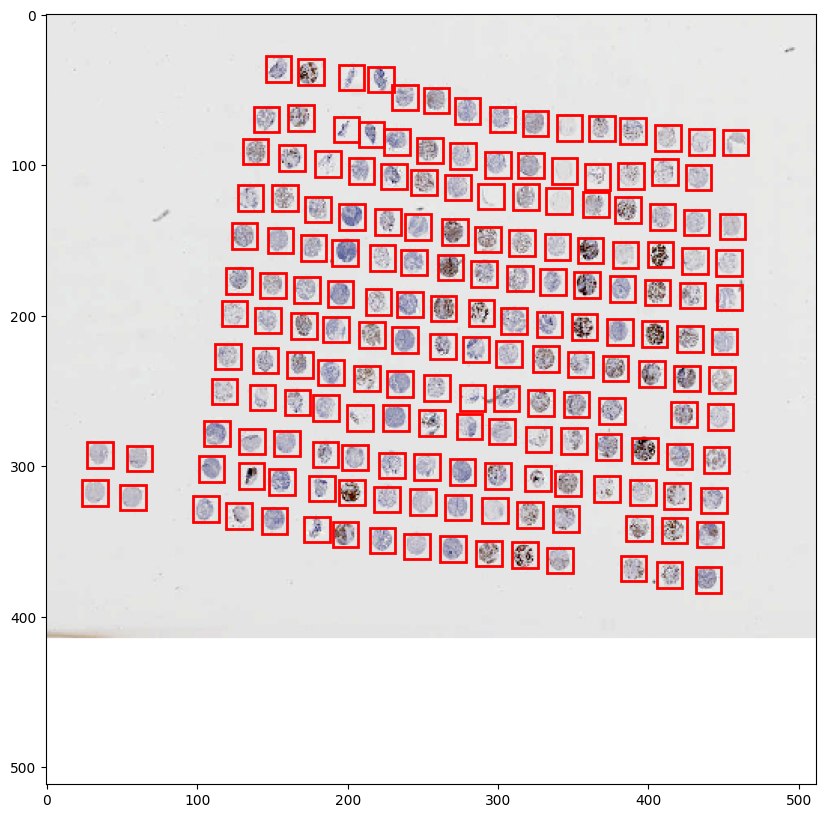

In [8]:
image_number = 16
# Example usage:
# Assuming `images` is your array of images loaded from the dataset and
# `boxes` is the array of bounding boxes for the corresponding images.
# Here we visualize the first image and its boxes.
plot_image_with_boxes(images[image_number], boxes[image_number])